In [18]:
import os
import shutil

import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

In [2]:
from sr_kspace import transforms as T

In [8]:
import torch
import torch.nn as nn
import torch.utils.data as torch_data

In [10]:
def tensor_for_model(tensor):
    tensor = tensor.transpose(-1, -2).transpose(-2, -3)
    tensor = tensor.unsqueeze(0)
    
    return tensor


def tensor_for_transform(tensor):
    tensor = tensor.transpose(-2, -3).transpose(-1, -2)
    tensor = tensor.squeeze(0)

    return tensor

## Load data

In [11]:
PATH_TO_SOURCE = 'data/ax_t2_source/'

PATH_TO_SOURCE_TRAIN = 'data/ax_t2_source_train'
PATH_TO_SOURCE_VAL = 'data/ax_t2_source_val'
PATH_TO_SOURCE_TEST = 'data/ax_t2_source_test'

os.makedirs(PATH_TO_SOURCE_TRAIN, exist_ok=True)
os.makedirs(PATH_TO_SOURCE_VAL, exist_ok=True)
os.makedirs(PATH_TO_SOURCE_TEST, exist_ok=True)

RANDOM_STATE = 42

In [12]:
samples = [s for s in os.listdir(PATH_TO_SOURCE) if s.endswith('npy')]

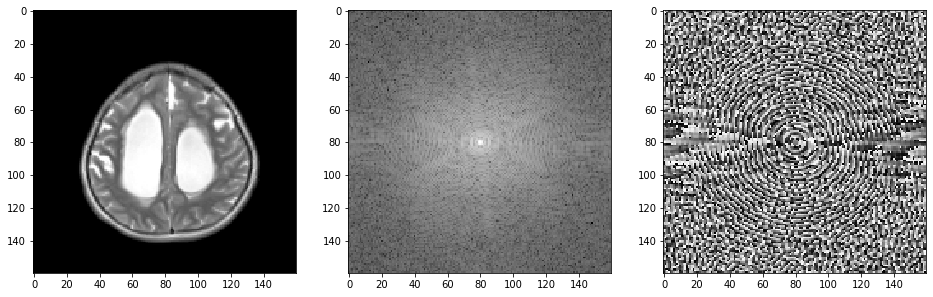

In [37]:
slice_lr = np.load(os.path.join(PATH_TO_SOURCE, samples[0]))[0]
slice_lr = resize(slice_lr, (160, 160), preserve_range=True).astype(np.float32)
slice_lr = torch.from_numpy(slice_lr)
slice_lr = torch.stack([slice_lr, torch.zeros_like(slice_lr)], dim=-1)

fig, axis = plt.subplots(1, 3, figsize=(16, 5))
axis[0].imshow(slice_lr[..., 0], cmap='gray')

k_space_lr = T.fft2(slice_lr)
k_space_lr /= k_space_lr.max()

spec = torch.log(T.complex_abs(k_space_lr))
phase = T.angle(k_space_lr) / np.pi
data = torch.stack([spec, phase], dim=-1)

axis[1].imshow(data[..., 0], cmap='gray')
axis[2].imshow(data[..., 1], cmap='gray')

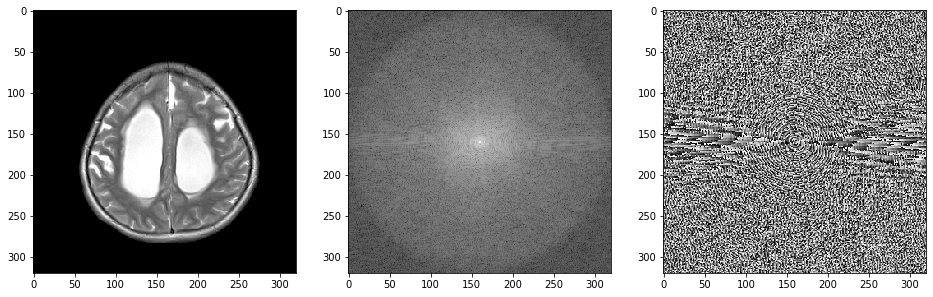

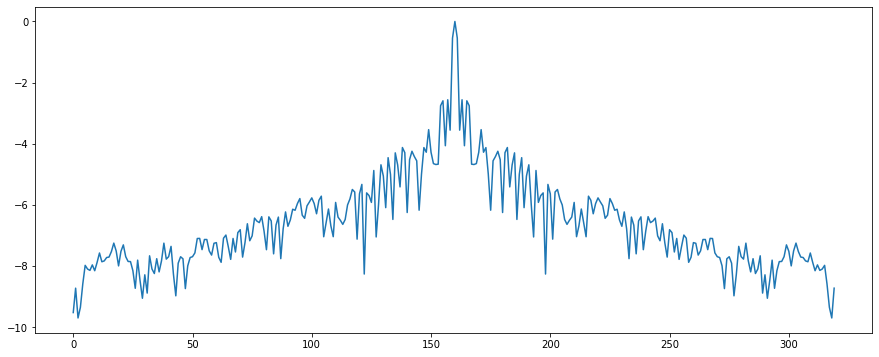

In [13]:
slice = np.load(os.path.join(PATH_TO_SOURCE, samples[0]))[0]
slice = torch.from_numpy(slice)
slice = torch.stack([slice, torch.zeros_like(slice)], dim=-1)

fig, axis = plt.subplots(1, 3, figsize=(16, 5))
axis[0].imshow(slice[..., 0], cmap='gray')

k_space = T.fft2(slice)
k_space /= k_space.max()

spec = torch.log(T.complex_abs(k_space))
phase = T.angle(k_space) / np.pi
data = torch.stack([spec, phase], dim=-1)

axis[1].imshow(data[..., 0], cmap='gray')
axis[2].imshow(data[..., 1], cmap='gray')

plt.figure(figsize=(15, 6))
plt.plot(spec[160], )

tensor(1.0455e-07)


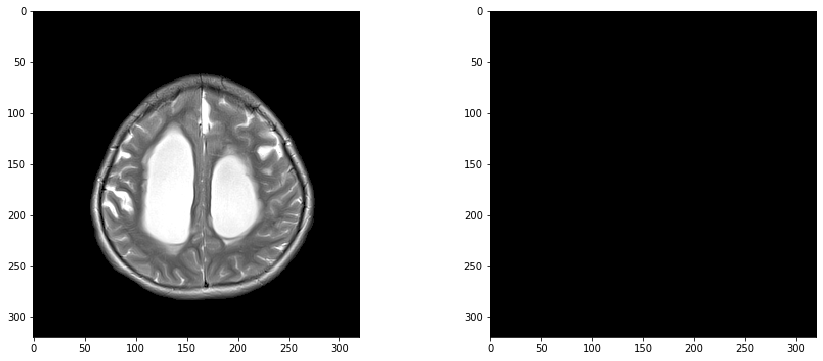

In [14]:
k_space = T.spec_phase_to_complex(spec, phase*np.pi)
#k_space = data[..., 0].unsqueeze(-1) * torch.stack([torch.cos(data[..., 1]), torch.sin(data[..., 1])], dim=-1)
img = T.ifft2(k_space)
img = T.complex_abs(img)

img -= img.min()
img /= img.max()

fig, axis = plt.subplots(1, 2, figsize=(15, 6))
axis[0].imshow(img, cmap='gray')
print(abs(img - slice[..., 0]).mean())
axis[1].imshow(abs(img - slice[..., 0]), vmin=0, vmax=1, cmap='gray')

In [76]:
class ResBlock(nn.Module):
    def __init__(self):
        super().__init__()

        self.start = nn.Sequential(nn.Conv2d(2, 64, 3, padding=1, bias=False),
                                  nn.ReLU()
                                  )

        self.body = nn.Sequential(nn.Conv2d(64, 64, 3, padding=1, bias=False),
                                  nn.BatchNorm2d(64, affine=False),
                                  nn.ReLU(),
                                  nn.Conv2d(64, 64, 3, padding=1, bias=False),
                                  nn.BatchNorm2d(64, affine=False)
                                 )  

        self.out = nn.Sequential(nn.Conv2d(64, 256, 3, padding=1, bias=False),
                                 nn.PixelShuffle(2),
                                 nn.ReLU(),
                                 nn.Conv2d(64, 2, 3, padding=1, bias=False)
                                )

    def forward(self, x):
        x = self.start(x)

        res = self.body(x)
        #res += x

        return self.out(res)

In [77]:
torch.random.manual_seed(RANDOM_STATE)

model = ResBlock()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
losses = []

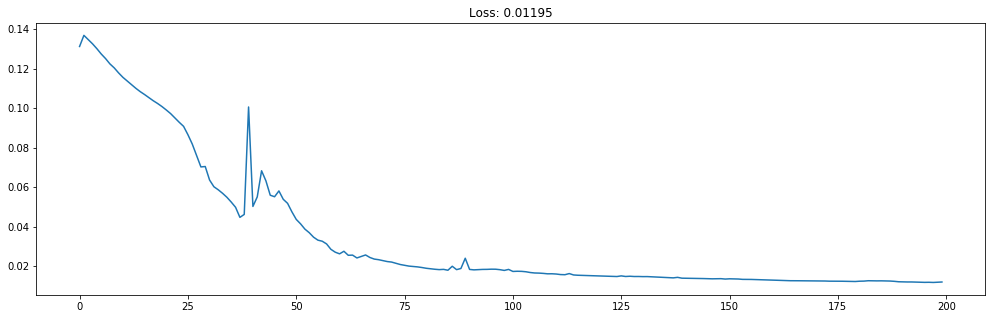

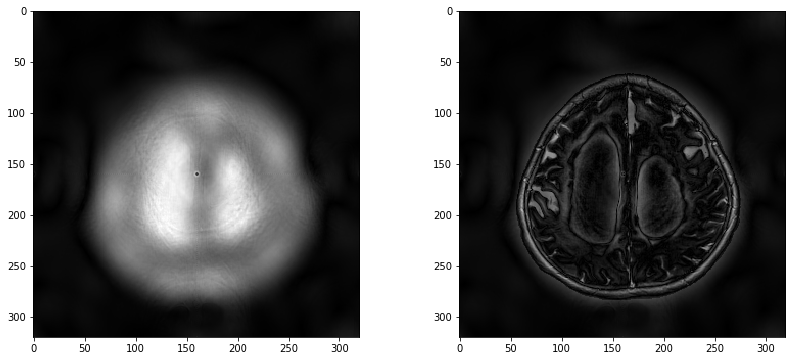

In [78]:
for i in tqdm(range(200)):
    out = model(tensor_for_model(k_space_lr))
    #print(out.shape)

    out = tensor_for_transform(out)
    out_img = T.k_space_to_image(out)

    loss = ((out_img - slice[..., 0])**2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())


plt.figure(figsize=(17, 5))
plt.plot(losses)
plt.title(f'Loss: {losses[-1]:.5f}')
#plt.yscale('log')

out_img = out_img.detach()

fig, axis = plt.subplots(1, 2, figsize=(14, 6))
axis[0].imshow(out_img, cmap='gray')
axis[1].imshow(abs(out_img - slice[..., 0]), cmap='gray', vmin=0, vmax=1)

## Data Loaders

In [25]:
class MRIDataSampler(torch_data.Dataset):
    def __init__(self, path_to_data, center_fractions, accelerations, 
                       shape=(1, 320, 320), seed=None, threshold=1e-7):
        super().__init__()

        self.images = [os.path.join(path_to_data, file) for file in os.listdir(path_to_data) 
                       if file.endswith('.npy')]
        self.images = sorted(self.images)

        self._mask_function = RandomMaskFunc(center_fractions=[center_fractions], 
                                             accelerations=[accelerations],
                                             seed=seed
                                            )
        self.mask = self._mask_function(shape, seed=seed).flatten().astype(bool)
        self.threshold = threshold

    def __len__(self):
        return len(self.images)

    def sample_slice(self, slice):
        slice_fft = np.fft.fft2(slice)
        slice_kspace = np.fft.fftshift(slice_fft)

        slice_kspace[:, :, ~self.mask] = 0

        slice_fft = np.fft.ifftshift(slice_kspace)
        sampled_image = np.fft.ifft2(slice_fft)

        sampled_image_abs = np.abs(sampled_image)
        sampled_image_abs -= sampled_image_abs.min()
        sampled_image_abs /= sampled_image_abs.max()

        sampled_image_abs[np.where(sampled_image_abs < self.threshold)] = 0

        return sampled_image_abs.astype(np.float32)

    def __getitem__(self, idx):

        slice = npy_load(self.images[idx])
        slice_sampled = self.sample_slice(slice)

        return self.images[idx], slice, slice_sampled

## Train test split

In [22]:
samples = [s for s in os.listdir(PATH_TO_SOURCE) if s.endswith('npy')]
unique_samples = list(set(s.split('_')[0] for s in samples))

train_samples, test_samples = train_test_split(unique_samples, test_size=0.4, random_state=RANDOM_STATE)
val_samples, test_samples = train_test_split(test_samples, test_size=0.5, random_state=RANDOM_STATE)

print(len(train_samples), len(val_samples), len(test_samples))

4898 1633 1633


In [23]:
def split_data(samples, src, dst):
    for sample in tqdm(samples):
        #break
        for i in range(1, 10):
            f = f'{sample}_{i}.npy'
            shutil.copy(os.path.join(src, f), os.path.join(dst, f))


split_data(train_samples, PATH_TO_SOURCE, PATH_TO_SOURCE_TRAIN)
split_data(val_samples, PATH_TO_SOURCE, PATH_TO_SOURCE_VAL)
split_data(test_samples, PATH_TO_SOURCE, PATH_TO_SOURCE_TEST)

## Data sampling

NameError: name 'RandomMaskFunc' is not defined

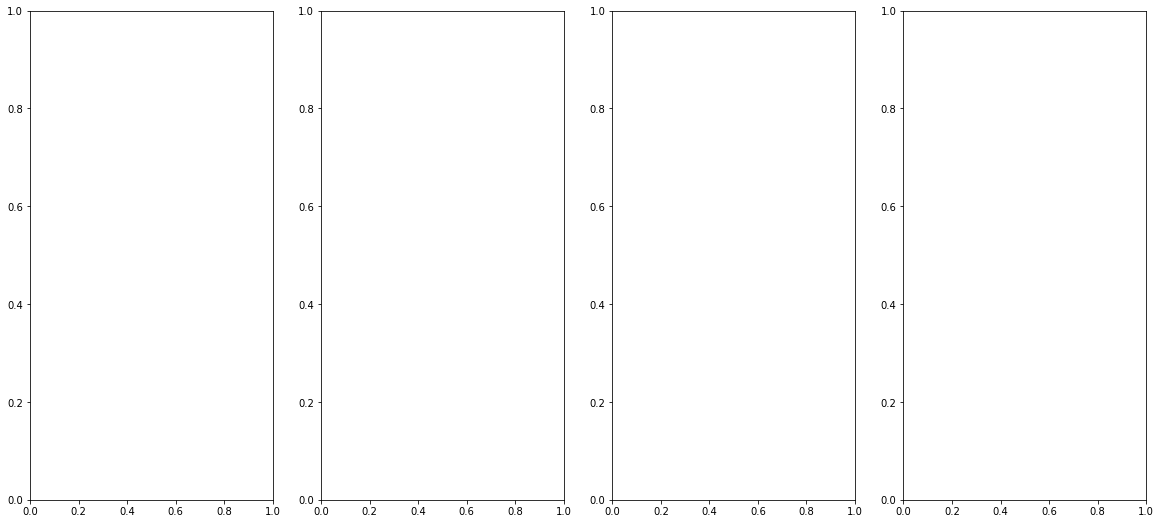

In [26]:
accelerations = [2, 4, 8]
center_fractions = [0.04, 0.08]

i = np.random.randint(0, len(os.listdir(PATH_TO_SOURCE_TRAIN)))

sampled_slices = []

for center_frac in center_fractions:
    fig, axis = plt.subplots(1, len(accelerations)+1, figsize=(20, 9))

    for j, acceleration in enumerate(accelerations, 1):
        train_loader = MRIDataSampler(PATH_TO_SOURCE_TRAIN, center_frac, acceleration, 
                                     seed=RANDOM_STATE, threshold=1e-5)

        name, slice, slice_sampled = train_loader.__getitem__(i)
        sampled_slices.append(slice_sampled)

        axis[j].imshow(slice_sampled[0], cmap='gray', vmin=0, vmax=1)
        axis[j].set_title(f'x{acceleration} acceleration, {center_frac} center fractions', fontsize=12)

    axis[0].imshow(slice[0], cmap='gray', vmin=0, vmax=1)
    axis[0].set_title('Source', fontsize=12)

    plt.show()

In [ ]:
for a, sampled_slice in zip(accelerations, sampled_slices):
    print(f'X{a} acceleration:')
    compare_imgs(slice, sampled_slice)

    print()

In [8]:
acceleration = 8
center_fraction = 0.08
parts = ['train', 'val', 'test']
label = f'sampled_x{acceleration}'

for part in parts:

    if part == 'train':
        path_to_sources = PATH_TO_SOURCE_TRAIN
    elif part == 'val':
        path_to_sources = PATH_TO_SOURCE_VAL
    elif part == 'test':
        path_to_sources = PATH_TO_SOURCE_TEST
    else:
        raise ValueError()

    path_to_save = f'data/ax_t2_{label}_{part}/'
    print(path_to_sources, path_to_save, sep=' -> ')
    os.makedirs(path_to_save, exist_ok=True)

    for path, _, slice_sampled in tqdm(MRIDataSampler(path_to_sources, center_fraction, 
                                                      acceleration, seed=RANDOM_STATE, threshold=1e-5)):
        name = os.path.split(path)[1]

        with open(os.path.join(path_to_save, name), 'wb') as f:
            np.save(f, slice_sampled)

data/ax_t2_single_source_train -> data/ax_t2_single_sampled_x8_train/



data/ax_t2_single_source_val -> data/ax_t2_single_sampled_x8_val/



data/ax_t2_single_source_test -> data/ax_t2_single_sampled_x8_test/
